Most of these data are time series. We can use R's STL to differentiate seasonal, trend and residual components. (It looks slightly better and smooth when compared with `statsmodels`'s seasonal_decompose.)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from rpy2.robjects import r

from IPython.display import display, HTML
%matplotlib inline

In [2]:
records_iq = pd.read_csv(
    './generated/1-features-iq.csv', 
    parse_dates=['week_start_date'], 
    index_col='week_start_date')
records_sj = pd.read_csv(
    './generated/1-features-sj.csv', 
    parse_dates=['week_start_date'], 
    index_col='week_start_date')

Impute data using linear interpolation to get a first approximation. 

In [3]:
records_iq_i1 = records_iq.interpolate().drop(['weekofyear'], axis=1)
records_sj_i1 = records_sj.interpolate().drop(['weekofyear'], axis=1)

A moving average to smooth things out. 

In [4]:
records_iq_i1 = records_iq_i1.rolling(5).mean().bfill()
records_sj_i1 = records_sj_i1.rolling(5).mean().bfill()

In [5]:
def stl_decompose(df, column, freq=52):
    dfd = pd.DataFrame(index=df.index)
    series = list(df[column].values)
    length = len(series)
    rts = r.ts(series, frequency=freq)
    decomposed = list(r.stl(rts, 'periodic', robust=True).rx2('time.series'))
    dfd['trend'] = decomposed[length:2*length]
    dfd['seasonal'] = decomposed[0:length]
    dfd['residuals'] = decomposed[2*length:3*length]
    
    return dfd

In [6]:
def stl_multi_decompose(df):
    trend = pd.DataFrame(index=df.index)
    seasonal = pd.DataFrame(index=df.index)
    residuals = pd.DataFrame(index=df.index)
    
    for col in df.columns:
        dfd = stl_decompose(df, col)
        trend[col] = dfd['trend']
        seasonal[col] = dfd['seasonal']
        residuals[col] = dfd['residuals']
    
    display(HTML(pd.DataFrame({
        'trend_mean': trend.mean(), 'seasonal_mean': seasonal.mean(), 'residuals_mean': residuals.mean(), 
        'trend_std': trend.std(), 'seasonal_std': seasonal.std(), 'residuals_std': residuals.std()
    }).to_html()))
    return {'trend': trend, 'seasonal': seasonal, 'residuals': residuals}

In [7]:
def correlation_heatmap_drop(df, title, f):
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    corr_hm = sns.heatmap(corr)
    plt.title(title)
    
    corr_upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in corr_upper.columns 
               if any(corr_upper[column] > f) or any(corr_upper[column] < -f)]
    return to_drop

In [8]:
def drop_extreme_correlated(dec_df, f=0.95):
    for k, v in dec_df.items():
        to_drop = correlation_heatmap_drop(v, 'Iquitos' + k, f)
        print('Dropping ' + str(to_drop) + ' in ' + k)
        v.drop(to_drop, axis=1, inplace=True)

In [9]:
dec_iq = stl_multi_decompose(records_iq_i1)

,trend_mean,seasonal_mean,residuals_mean,trend_std,seasonal_std,residuals_std
precipitation_amt_mm,62.288838,-1.061234e-09,0.484366,5.952555,14.126317,13.700119
reanalysis_air_temp_k,24.667522,-1.405959e-11,0.026288,0.300340,0.732190,0.419589
reanalysis_dew_point_temp_k,22.354509,-1.678395e-10,0.011480,0.475631,0.981915,0.519132
reanalysis_max_air_temp_k,33.862402,1.440062e-10,0.034787,0.507520,1.511159,0.854227
reanalysis_min_air_temp_k,19.738581,-1.554921e-10,-0.048803,0.403219,1.013174,0.543066
reanalysis_precip_amt_kg_per_m2,58.775171,-3.120781e-09,2.313795,10.725103,21.609909,20.617652
reanalysis_relative_humidity_percent,89.392095,-7.198312e-10,-0.513332,1.278030,4.631959,3.321610
reanalysis_tdtr_k,9.143271,2.459960e-10,0.080292,0.417471,1.592905,0.909288
station_precip_mm,52.514367,2.436686e-09,2.952275,18.819923,11.672516,23.627675
ndvi,0.257698,2.405775e-14,0.000254,0.010719,0.026992,0.026283


Dropping [] in trend
Dropping ['reanalysis_tdtr_k'] in seasonal
Dropping [] in residuals


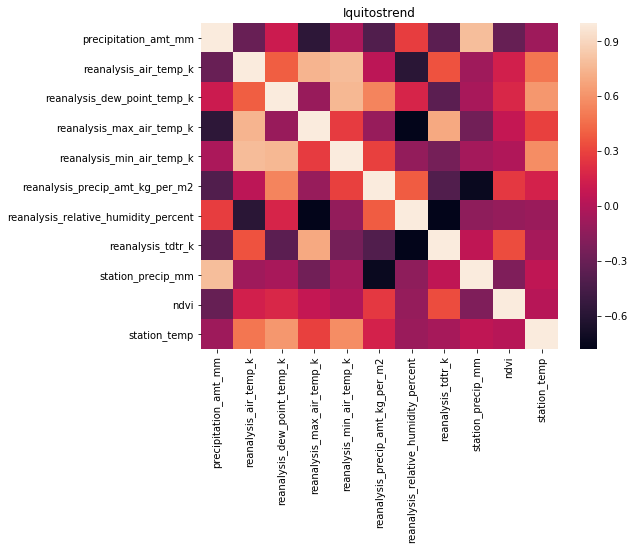

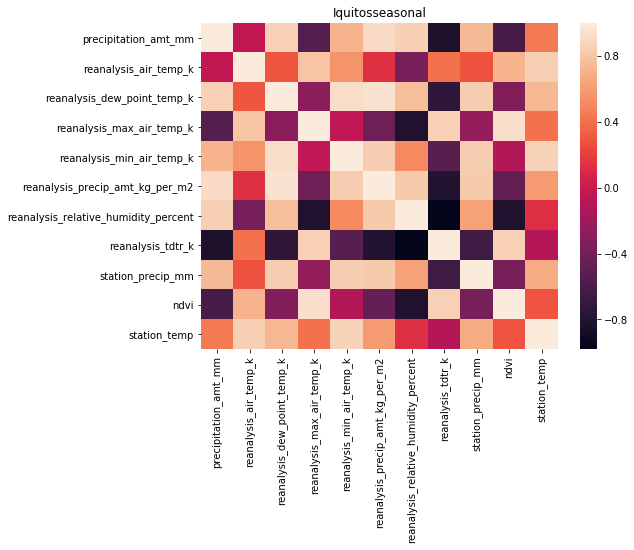

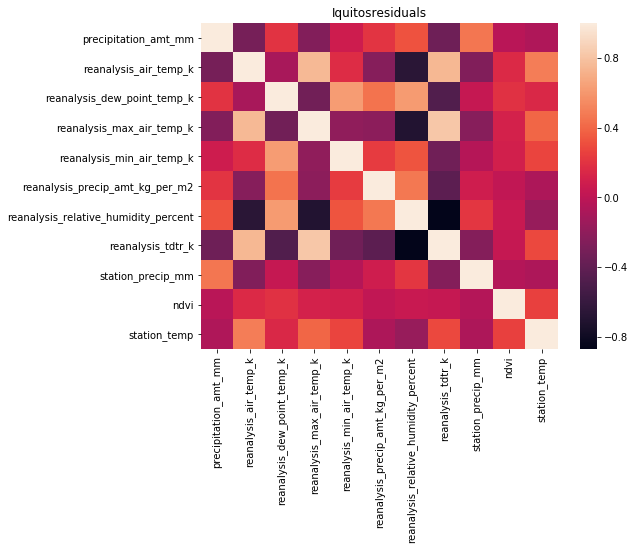

In [10]:
drop_extreme_correlated(dec_iq)

In [11]:
dec_sj = stl_multi_decompose(records_sj_i1)

,trend_mean,seasonal_mean,residuals_mean,trend_std,seasonal_std,residuals_std
precipitation_amt_mm,30.544192,-5.197084e-10,2.866361e+00,6.274992,15.439955,16.318039
reanalysis_precip_amt_kg_per_m2,25.719458,6.416119e-10,3.236473e+00,5.883520,8.956827,17.121044
reanalysis_relative_humidity_percent,78.473855,-4.873148e-11,1.399145e-02,1.133561,1.528833,1.472794
reanalysis_tdtr_k,2.513107,-5.834453e-12,1.701119e-02,0.192199,0.142740,0.216360
station_precip_mm,26.296566,-9.728073e-10,2.020240e+00,5.376923,7.929668,13.100615
ndvi_n,0.053906,-5.806725e-12,3.017644e-03,0.046747,0.012843,0.041001
ndvi_s,0.170327,1.244274e-12,-7.074309e-07,0.014226,0.010230,0.023585
reanalysis_temp,25.170618,-2.013459e-11,-3.007904e-02,0.321705,1.118089,0.297886
station_temp,27.137343,-1.399277e-11,-1.255963e-02,0.312459,1.208617,0.374886


Dropping [] in trend
Dropping ['station_temp'] in seasonal
Dropping [] in residuals


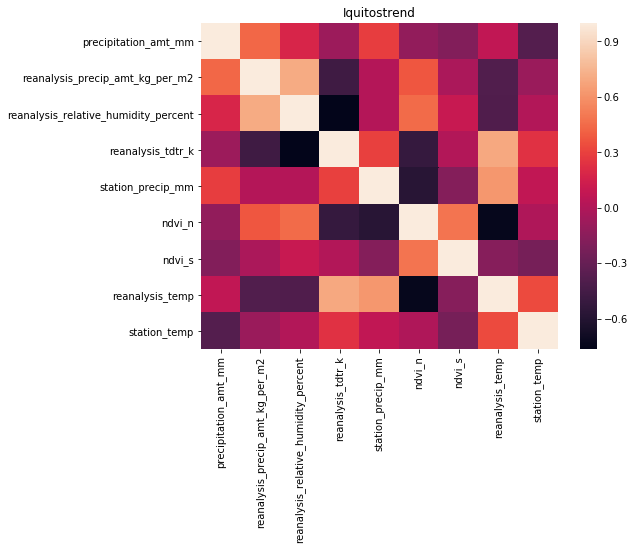

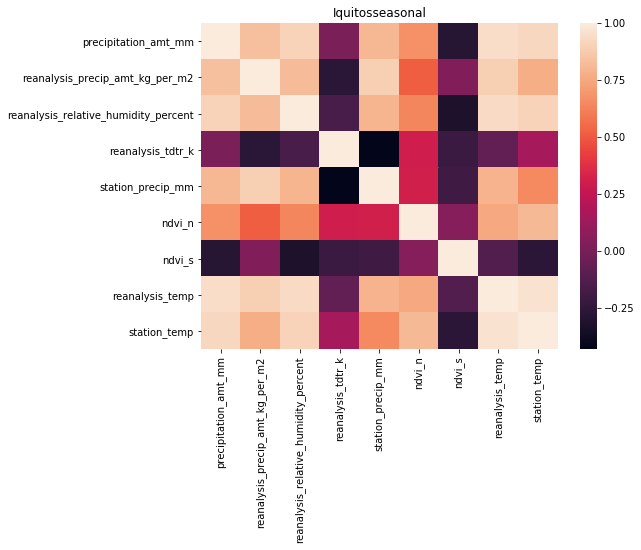

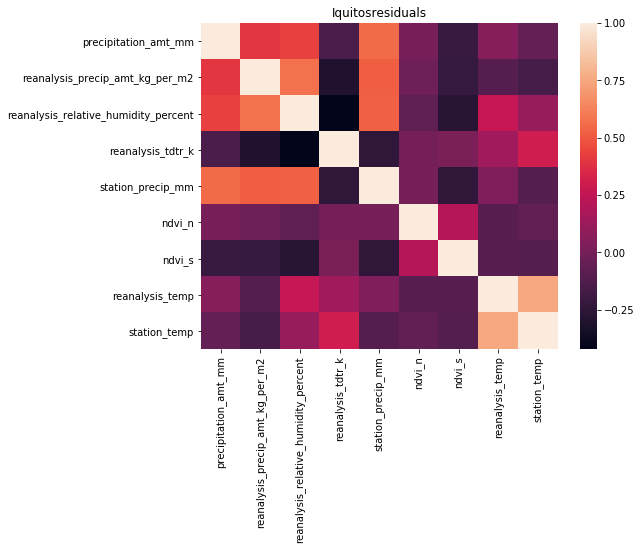

In [12]:
drop_extreme_correlated(dec_sj)

NDVIs show correlations inside residuals. Maybe this is not exactly a time series. 

In [13]:
stl_dec_iq = pd.concat(map(lambda kvp: kvp[1].add_prefix(kvp[0] + '_'), dec_iq.items()), axis=1)
stl_dec_sj = pd.concat(map(lambda kvp: kvp[1].add_prefix(kvp[0] + '_'), dec_sj.items()), axis=1)

In [14]:
stl_dec_iq.describe()

,trend_precipitation_amt_mm,trend_reanalysis_air_temp_k,trend_reanalysis_dew_point_temp_k,trend_reanalysis_max_air_temp_k,trend_reanalysis_min_air_temp_k,trend_reanalysis_precip_amt_kg_per_m2,trend_reanalysis_relative_humidity_percent,trend_reanalysis_tdtr_k,trend_station_precip_mm,trend_ndvi,...,residuals_reanalysis_air_temp_k,residuals_reanalysis_dew_point_temp_k,residuals_reanalysis_max_air_temp_k,residuals_reanalysis_min_air_temp_k,residuals_reanalysis_precip_amt_kg_per_m2,residuals_reanalysis_relative_humidity_percent,residuals_reanalysis_tdtr_k,residuals_station_precip_mm,residuals_ndvi,residuals_station_temp
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,...,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,62.288838,24.667522,22.354509,33.862402,19.738581,58.775171,89.392095,9.143271,52.514367,0.257698,...,0.026288,0.011480,0.034787,-0.048803,2.313795,-0.513332,0.080292,2.952275,0.000254,-0.009476
std,5.952555,0.300340,0.475631,0.507520,0.403219,10.725103,1.278030,0.417471,18.819923,0.010719,...,0.419589,0.519132,0.854227,0.543066,20.617652,3.321610,0.909288,23.627675,0.026283,0.317485
min,49.209132,24.174770,20.313500,33.091751,18.978408,40.226720,86.777638,8.099216,20.927979,0.243736,...,-2.106011,-1.932357,-3.563394,-2.315672,-51.251682,-20.900204,-3.075782,-79.438902,-0.073956,-1.214464
25%,58.886904,24.478053,22.229290,33.448015,19.426453,50.349088,88.418997,8.854698,37.901649,0.250378,...,-0.230008,-0.296419,-0.437661,-0.320966,-9.538634,-1.640672,-0.427820,-9.758525,-0.017795,-0.195563
50%,62.166235,24.568699,22.420140,33.839439,19.750863,55.939789,89.653790,9.283697,47.531532,0.256231,...,0.008682,0.021822,0.019996,-0.012050,-0.727833,-0.070314,0.031854,-0.303796,-0.000092,0.007873
75%,66.645322,24.811894,22.581984,34.209813,20.018285,69.210982,90.325541,9.494747,74.553157,0.262203,...,0.225772,0.292391,0.446424,0.281689,12.716136,1.329174,0.530824,11.773333,0.016803,0.185309
max,74.825453,25.523121,23.086966,35.147650,20.568743,76.667549,91.703190,9.651448,80.935187,0.310530,...,2.106434,2.517969,3.889250,1.402551,96.329156,6.700940,4.600783,112.631344,0.083633,1.068196


In [15]:
stl_dec_sj.describe()

,trend_precipitation_amt_mm,trend_reanalysis_precip_amt_kg_per_m2,trend_reanalysis_relative_humidity_percent,trend_reanalysis_tdtr_k,trend_station_precip_mm,trend_ndvi_n,trend_ndvi_s,trend_reanalysis_temp,trend_station_temp,seasonal_precipitation_amt_mm,...,seasonal_reanalysis_temp,residuals_precipitation_amt_mm,residuals_reanalysis_precip_amt_kg_per_m2,residuals_reanalysis_relative_humidity_percent,residuals_reanalysis_tdtr_k,residuals_station_precip_mm,residuals_ndvi_n,residuals_ndvi_s,residuals_reanalysis_temp,residuals_station_temp
count,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1.196000e+03,...,1.196000e+03,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1196.000000,1.196000e+03,1196.000000,1196.000000
mean,30.544192,25.719458,78.473855,2.513107,26.296566,0.053906,0.170327,25.170618,27.137343,-5.197084e-10,...,-2.013459e-11,2.866361,3.236473,0.013991,0.017011,2.020240,0.003018,-7.074309e-07,-0.030079,-0.012560
std,6.274992,5.883520,1.133561,0.192199,5.376923,0.046747,0.014226,0.321705,0.312459,1.543996e+01,...,1.118089e+00,16.318039,17.121044,1.472794,0.216360,13.100615,0.041001,2.358542e-02,0.297886,0.374886
min,19.866081,13.884001,75.882219,2.219075,17.478831,-0.012648,0.131825,24.601924,26.410185,-2.497697e+01,...,-1.655154e+00,-29.219315,-28.587777,-5.801087,-0.586665,-30.575916,-0.136502,-1.175258e-01,-1.944515,-1.926310
25%,25.816071,21.633969,77.564053,2.336193,22.011222,0.013510,0.160311,24.844464,26.936046,-1.537953e+01,...,-1.216818e+00,-7.170535,-5.507954,-0.856416,-0.114383,-5.898303,-0.021783,-1.378043e-02,-0.164457,-0.245746
50%,30.409463,25.662408,78.521360,2.491679,25.047251,0.046771,0.169177,25.214792,27.114056,3.630702e+00,...,1.930427e-01,-0.270455,-0.209828,-0.014886,-0.004825,-0.357960,0.001103,-2.049376e-04,0.000532,-0.004012
75%,34.291533,29.226078,79.356095,2.690071,29.899012,0.089839,0.178193,25.410558,27.306777,1.318595e+01,...,1.058154e+00,9.377410,7.352605,0.873940,0.130960,8.025265,0.023900,1.459567e-02,0.142940,0.242306
max,44.955643,40.077032,80.367455,2.862917,42.397194,0.176591,0.220363,25.870043,28.018341,2.684130e+01,...,1.430521e+00,107.345731,156.869537,5.302590,1.020498,74.762586,0.218340,8.986524e-02,0.766861,1.219132


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000206A27880F0>,
      dtype=object)

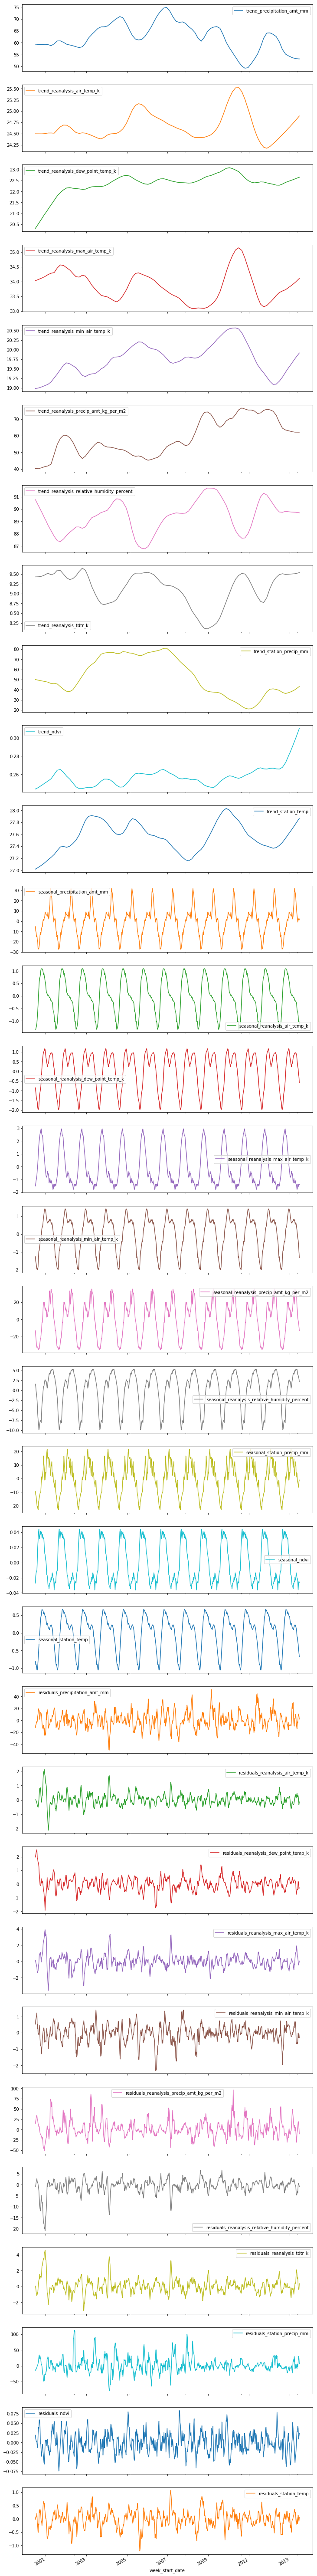

In [16]:
stl_dec_iq.plot(subplots=True, sharey=False, figsize=(12, 120))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000206A248FBA8>,
      dtype=object)

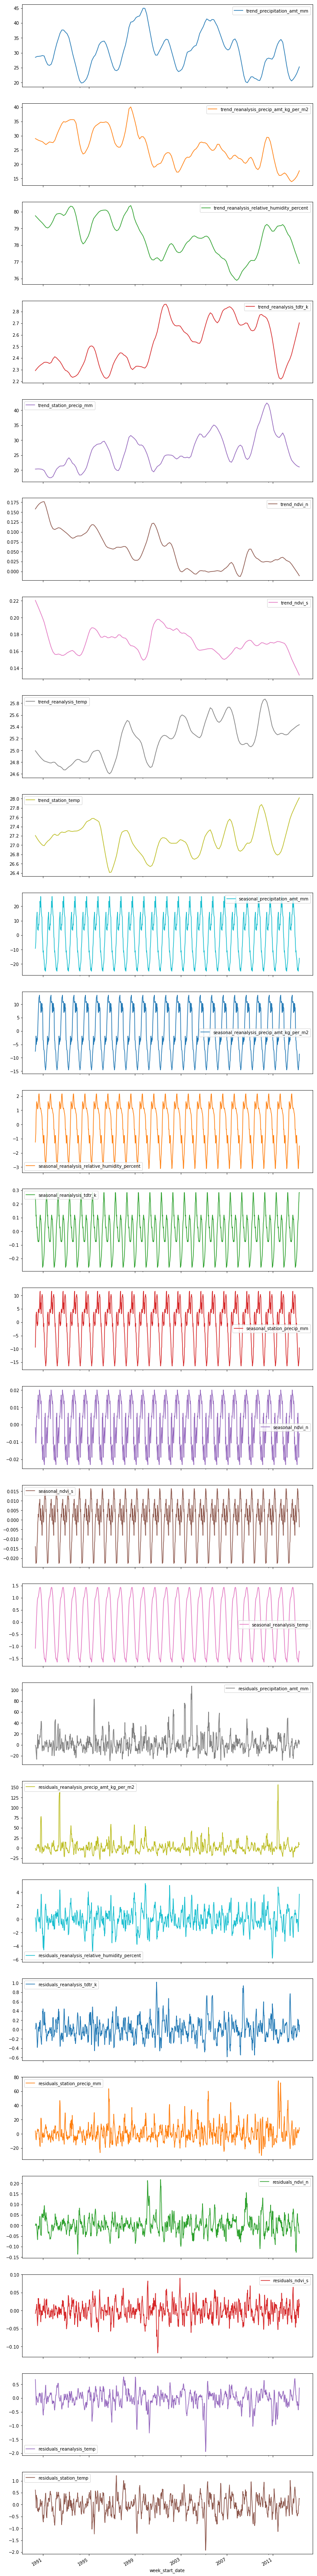

In [17]:
stl_dec_sj.plot(subplots=True, sharey=False, figsize=(12, 120))

In [18]:
stl_dec_iq.to_csv('./generated/2-time-dec-features-iq.csv', index_label='week_start_date')
stl_dec_sj.to_csv('./generated/2-time-dec-features-sj.csv', index_label='week_start_date')

---

 Try loading total cases:

In [19]:
training_targets_iq = pd.read_csv(
    './generated/1-labels-train-iq.csv', 
    parse_dates=['week_start_date'], 
    index_col='week_start_date')
training_targets_sj = pd.read_csv(
    './generated/1-labels-train-sj.csv', 
    parse_dates=['week_start_date'], 
    index_col='week_start_date')

In [20]:
# int not supported - float only
training_targets_iq['total_cases'] += 0.0
training_targets_sj['total_cases'] += 0.0

In [21]:
dec_targets_iq = stl_decompose(training_targets_iq, 'total_cases')
dec_targets_sj = stl_decompose(training_targets_sj, 'total_cases')

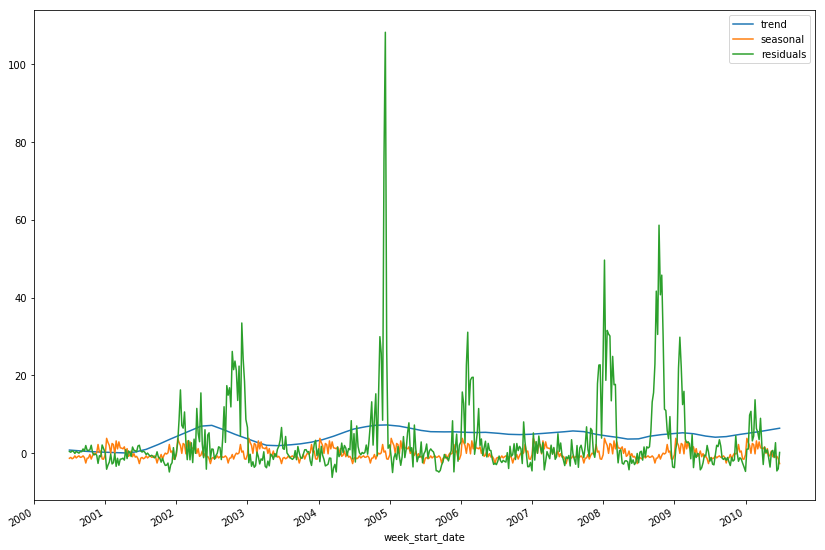

In [22]:
dec_targets_iq.plot(figsize=(14, 10))

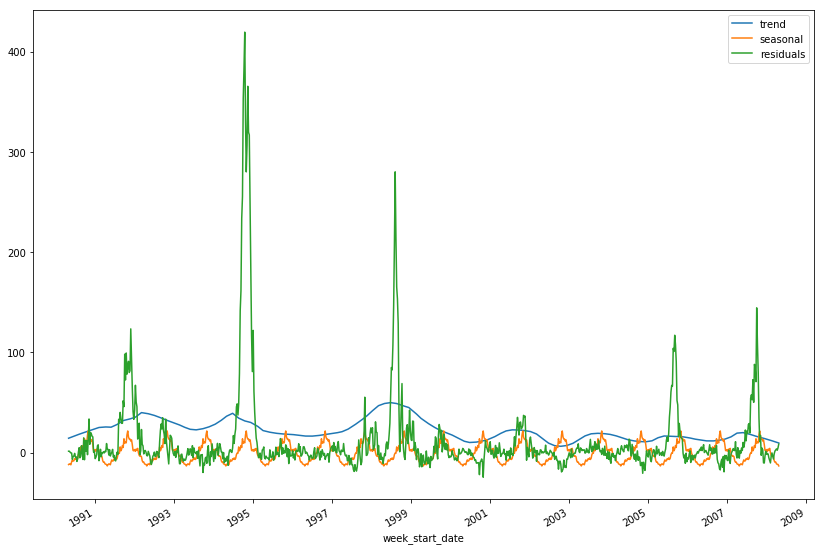

In [23]:
dec_targets_sj.plot(figsize=(14, 10))

Looks pointless. 

In [24]:
dec_targets_iq.to_csv('./generated/1-labels-iq.csv')
dec_targets_sj.to_csv('./generated/1-labels-sj.csv')